In [6]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

print("loaded packages\n")

loaded packages



In [32]:
coral_df = pd.read_csv("/work/hs325/World_Corals/Cleaned data CSVs/richness_qc_clean.csv")
met_df = pd.read_csv("/work/hs325/World_Corals/Cleaned data CSVs/metabolite_clean.csv")

coral_df['scleractinia'] = np.where(coral_df['host_order'] == 'Scleractinia', 1, 0)
met_df['refined_origin'] = met_df['refined_origin'].str.replace('Host', 'Coral')
met_df = met_df[met_df['refined_origin'] == 'Coral']

print("loaded and cleaned data\n")

X = coral_df[coral_df.columns.intersection(met_df['metabolite'])]
y = coral_df['scleractinia']
# X = X.to_numpy()
# y = y.to_numpy()

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

/tmp/ipykernel_3036701/3432494596.py:1: DtypeWarning: Columns (8,17) have mixed types. Specify dtype option on import or set low_memory=False.
  coral_df = pd.read_csv("/work/hs325/World_Corals/Cleaned data CSVs/richness_qc_clean.csv")


loaded and cleaned data



### Feature Selection

In [4]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_classif

## variance threshold doesn't remove enough testing Kbest and percentile

In [8]:
# Initialize a dictionary to store the dataframes
importance_storage = {}

# Define your datasets and models
datasets = {
    "KBest_500": SelectKBest(f_classif, k=500),
    "Percentile_5": SelectPercentile(f_classif, percentile=5)
}

models = {
    "RandomForest": RandomForestClassifier(random_state=88, n_jobs=-1),
    "XGBoost": XGBClassifier(random_state=88, use_label_encoder=False, eval_metric='logloss')
}

# Original feature names from the intersection
feature_names = coral_df.columns.intersection(met_df['metabolite']).values

for d_name, selector in datasets.items():
    selector.fit(X_train, y_train)
    X_train_sel = selector.transform(X_train)
    X_test_sel = selector.transform(X_test)
    
    mask = selector.get_support()
    selected_features = feature_names[mask]
    
    for m_name, model in models.items():
        model.fit(X_train_sel, y_train)
        y_pred = model.predict(X_test_sel)
        
        print(f"\n{m_name} on {d_name}")
        print(confusion_matrix(y_test, y_pred))
        
        feat_imp_df = pd.DataFrame({
            'Metabolite': selected_features,
            'Importance': model.feature_importances_
        }).sort_values(by='Importance', ascending=False).reset_index(drop=True)
        
        importance_storage[f"{m_name}_{d_name}"] = feat_imp_df

# importance_storage

/hpc/group/schultzlab/hs325/miniconda3/envs/gsAI/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 208  322  330  441  514  798 1015 1234 2124 2781 2900 3034 3156] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/hpc/group/schultzlab/hs325/miniconda3/envs/gsAI/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw



RandomForest on KBest_500
[[28  0]
 [ 0 86]]


/hpc/group/schultzlab/hs325/miniconda3/envs/gsAI/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:24:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost on KBest_500
[[28  0]
 [ 0 86]]


/hpc/group/schultzlab/hs325/miniconda3/envs/gsAI/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 208  322  330  441  514  798 1015 1234 2124 2781 2900 3034 3156] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/hpc/group/schultzlab/hs325/miniconda3/envs/gsAI/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw



RandomForest on Percentile_5
[[28  0]
 [ 0 86]]


/hpc/group/schultzlab/hs325/miniconda3/envs/gsAI/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:24:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost on Percentile_5
[[28  0]
 [ 0 86]]


### Perm importance collinear features

In [9]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr
from collections import defaultdict

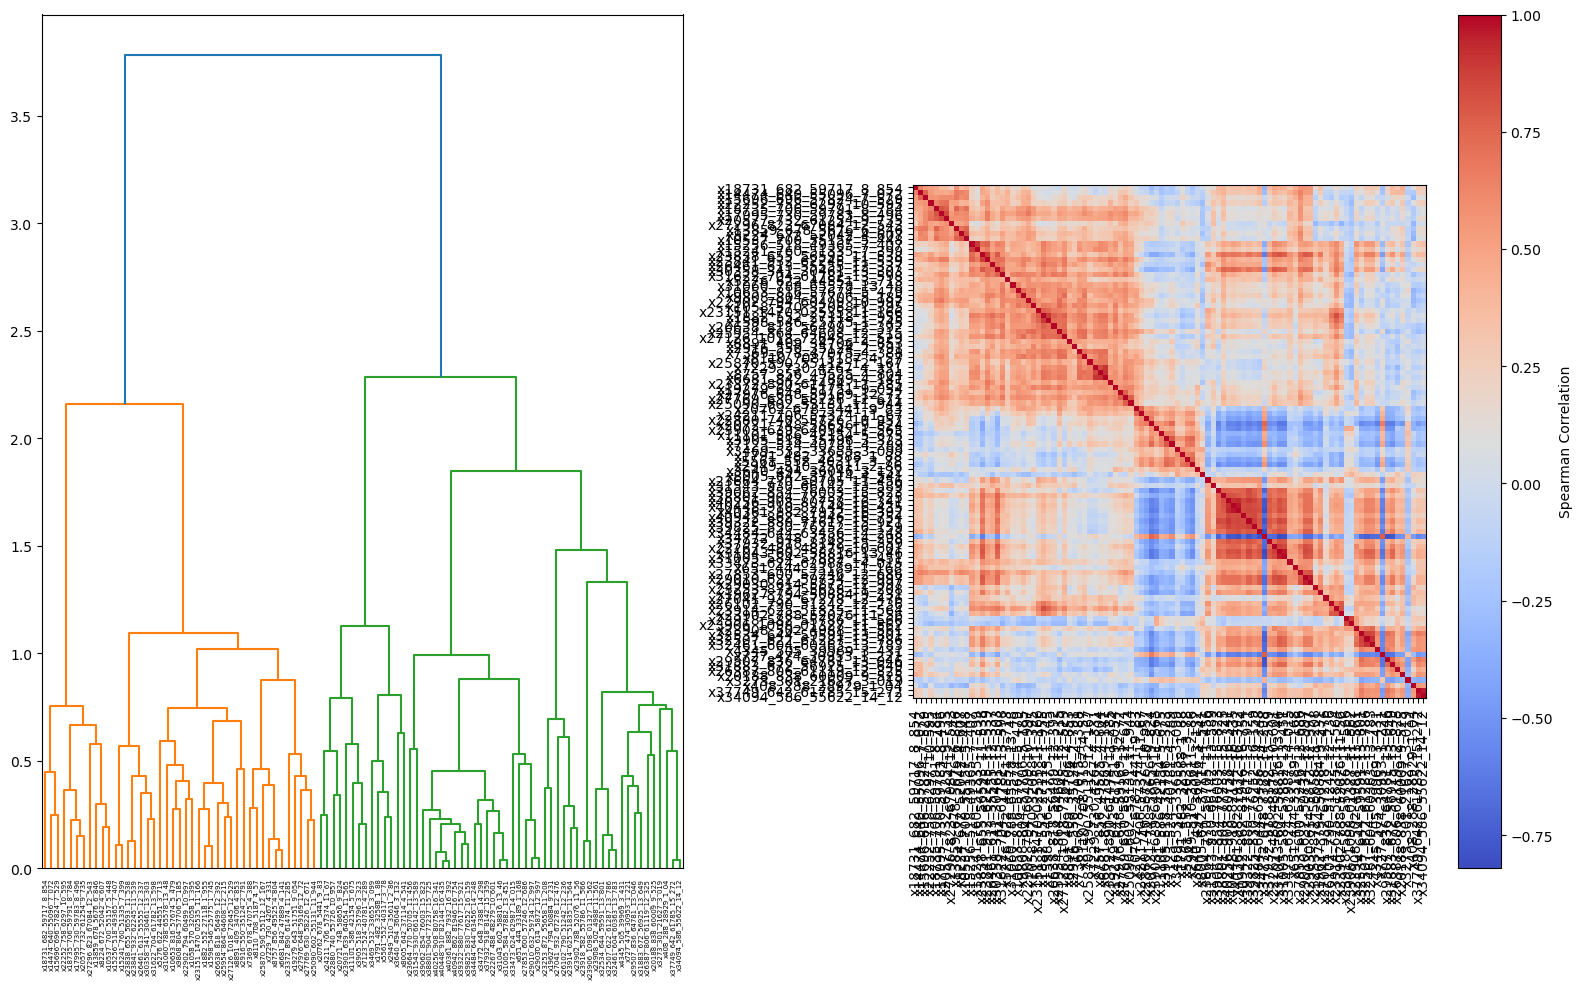

In [14]:
# top_100_metabolites = importance_storage["RandomForest_KBest_500"].head(100)['Metabolite'].values
top_100_metabolites = importance_storage["XGBoost_KBest_500"].head(100)['Metabolite'].values
## best downstream model accuracy is RF KBest500 with 93% using just 4 features

X_df = pd.DataFrame(X, columns=coral_df.columns.intersection(met_df['metabolite']))
X_subset = X_df[top_100_metabolites]

corr = spearmanr(X_subset).correlation
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))

dendro = hierarchy.dendrogram(
    dist_linkage, labels=top_100_metabolites.tolist(), ax=ax1, leaf_rotation=90
)

im = ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]], cmap='coolwarm')
ax2.set_xticks(np.arange(len(top_100_metabolites)))
ax2.set_yticks(np.arange(len(top_100_metabolites)))
ax2.set_xticklabels([top_100_metabolites[i] for i in dendro["leaves"]], rotation=90)
ax2.set_yticklabels([top_100_metabolites[i] for i in dendro["leaves"]])

fig.colorbar(im, ax=ax2, label='Spearman Correlation')
fig.tight_layout()
plt.show()

In [15]:
from collections import defaultdict
from scipy.cluster import hierarchy

cluster_ids = hierarchy.fcluster(dist_linkage, 1, criterion="distance")

cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)

selected_features_indices = [v[0] for v in cluster_id_to_feature_ids.values()]
selected_features_names = feature_names[selected_features_indices]

print(f"Reduced feature set from {len(feature_names)} to {len(selected_features_names)} clusters.")

X_train_sel = X_train[:, selected_features_indices]
X_test_sel = X_test[:, selected_features_indices]

clf_sel = RandomForestClassifier(n_estimators=100, random_state=123, n_jobs=-1)
clf_sel.fit(X_train_sel, y_train)

accuracy = clf_sel.score(X_test_sel, y_test)
print(f"Baseline accuracy on test data with redundant features removed: {accuracy:.2f}")

## print selected feature names
print("Selected feature names after clustering:")
for name in selected_features_names:
    print(name)

Reduced feature set from 3623 to 10 clusters.
Baseline accuracy on test data with redundant features removed: 0.99
Selected feature names after clustering:
x22863_768_59077_10_971
x3156_482_36064_2_937
x19279_643_51751_9_054
x22902_794_60499_10_997
x23174_724_5283_11_167
x19255_518_49318_9_043
x17948_659_51273_8_479
x9373_538_42397_5_038
x31043_602_58816_13_46
x27910_716_55909_12_685


In [28]:
import pandas as pd

# 1. Generate predictions from your trained model
y_pred = clf_sel.predict(X_test_sel)

# 2. Identify the indices where predictions do not match the truth
# This creates a boolean mask for the test set
missed_mask = y_pred != y_test

# 3. Use the original test indices to pull the metadata from coral_df
# We use .iloc[X_test_indices] assuming you have the original indices from your split
# If you used train_test_split, you likely have 'indices_test' or can use y_test.index
missed_samples_df = coral_df.loc[y_test.index][missed_mask]

# 4. Print the host_genus and host_species for those missed cases
print(f"Total missed classifications: {len(missed_samples_df)}")
print("-" * 30)
print(missed_samples_df[['host_genus', 'host_species']])

Total missed classifications: 1
------------------------------
    host_genus host_species
477        NaN          NaN


### Old VIPs and CSV saving

accuracy 0.9833
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        31
           1       1.00      0.98      0.99        89

    accuracy                           0.98       120
   macro avg       0.97      0.99      0.98       120
weighted avg       0.98      0.98      0.98       120



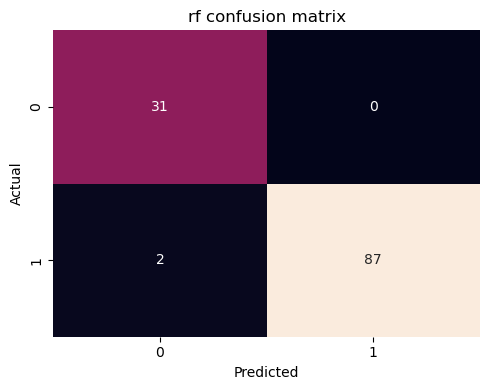

In [12]:
# RF best params =  OrderedDict({'max_depth': 19, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 17, 'n_estimators': 595})
rf_path = "models/RF_best_model.joblib"
rf = joblib.load(rf_path)
y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"accuracy {acc:.4f}")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True,cbar=False)
plt.title("rf confusion matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


accuracy 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        31
           1       1.00      1.00      1.00        89

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120



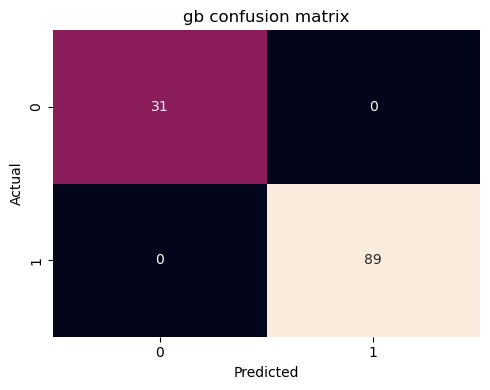

In [ ]:
# GB best params =  OrderedDict({'colsample_bytree': 0.5818992099512528, 'gamma': 0.721021236997679123, 'learning_rate': 0.3, 'max_depth': 15, 'min_child_weight': 1, 'n_estimators': 2000, 'subsample': 0.51024016759385})
gb_path = "models/GB_best_model.joblib"
gb = joblib.load(gb_path)
y_pred = gb.predict(X_test)
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"accuracy {acc:.4f}")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True,cbar=False)
plt.title("gb confusion matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


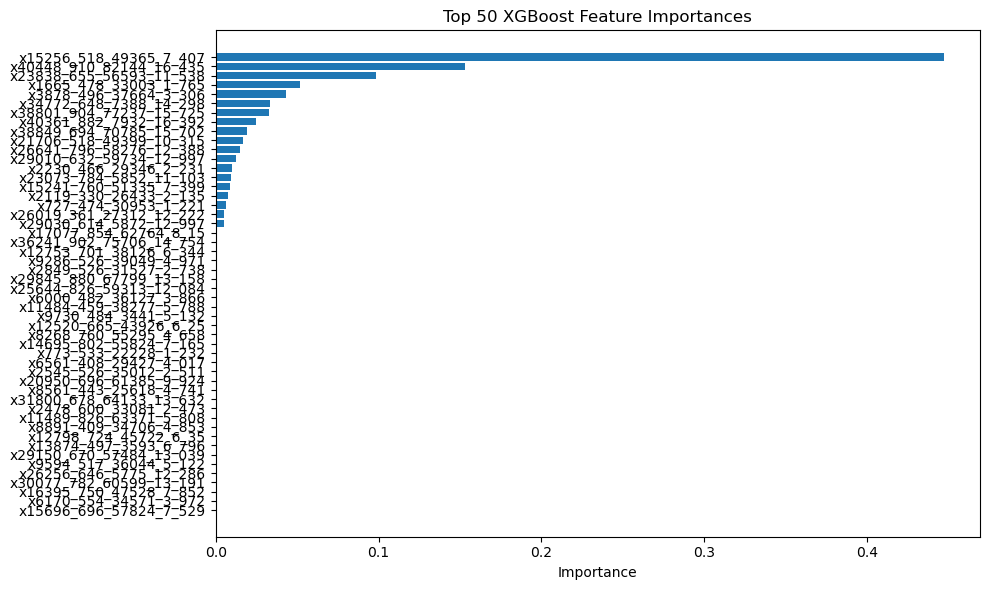

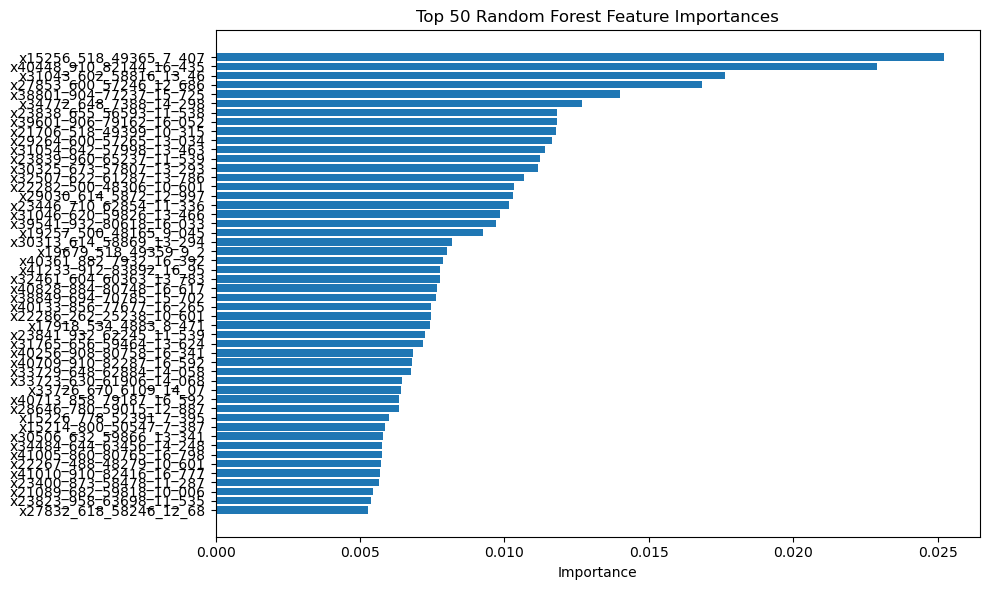

In [9]:
feature_names = coral_df.columns.intersection(met_df_coral['metabolite'])

def get_feature_importances_df(gb_importances, rf_importances, feature_names):
    
    gb_df = pd.DataFrame({
        'Feature': feature_names,
        'XGBoost_Importance': gb_importances
    })

    rf_df = pd.DataFrame({
        'Feature': feature_names,
        'RandomForest_Importance': rf_importances
    })

    merged_df = pd.merge(gb_df, rf_df, on='Feature', how='outer')
    
    merged_df = merged_df.set_index('Feature')
    merged_df['Total_Importance'] = merged_df['XGBoost_Importance'] + merged_df['RandomForest_Importance']
    merged_df = merged_df.sort_values(by='Total_Importance', ascending=False)
    merged_df = merged_df.drop(columns=['Total_Importance'])
    return merged_df

def plot_top_features(importances, feature_names, title, top_n=50):
    indices = np.argsort(importances)[::-1][:top_n]
    top_features = np.array(feature_names)[indices]
    top_importances = importances[indices]

    plt.figure(figsize=(10, 6))
    plt.barh(range(len(top_features)), top_importances[::-1])
    plt.yticks(range(len(top_features)), top_features[::-1])
    plt.title(title)
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

feature_importance_comparison_df = get_feature_importances_df(
    gb.feature_importances_, 
    rf.feature_importances_, 
    feature_names
)

plot_top_features(gb.feature_importances_, feature_names, "Top 50 XGBoost Feature Importances", top_n=50)
plot_top_features(rf.feature_importances_, feature_names, "Top 50 Random Forest Feature Importances", top_n=50)

In [11]:
feature_importance_comparison_df.to_csv("featureimportancenov20.csv")